<a href="https://colab.research.google.com/github/ricardoinaciopt/seminars3b/blob/main/S3b_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [132]:
!pip install librosa
!rm -rf TIVlib
!git clone https://github.com/aframires/TIVlib.git
%cd TIVlib
!pip install soundfile

Cloning into 'TIVlib'...
remote: Enumerating objects: 216, done.
remote: Counting objects: 100% (153/153), done.
remote: Compressing objects: 100% (115/115), done.
remote: Total 216 (delta 73), reused 94 (delta 38), pack-reused 63 (from 1)
Receiving objects: 100% (216/216), 18.89 MiB | 6.83 MiB/s, done.
Resolving deltas: 100% (89/89), done.
/content/drive/MyDrive/Colab Notebooks/TIVlib


In [191]:
import os
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')
drive.mount('/content/drive/')
%cd /content/drive/My Drive/Colab Notebooks/ # use this if you want to extract features from the folder with songs

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Colab Notebooks


In [2]:
if not os.path.exists("music_folder"):
  print("Music data not found, extracting...")
  !unzip archive.zip -d music_folder
else:
  print("Music data already extracted.")
music_folder = '/content/drive/My Drive/Colab Notebooks/music_folder'
music_folder

Mounted at /content/drive/
/content/drive/My Drive/Colab Notebooks
Music data already extracted.


'/content/drive/My Drive/Colab Notebooks/music_folder'

In [3]:
import random
from IPython.display import Audio

def select_random_file_from_subfolder(directory_path):
    subfolders = [os.path.join(directory_path, d) for d in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, d))]
    if not subfolders:
        return None
    random_subfolder = random.choice(subfolders)
    print(f"Selected subfolder: {random_subfolder}")
    files = [f for f in os.listdir(random_subfolder) if os.path.isfile(os.path.join(random_subfolder, f))]
    print(f"Files in selected subfolder: {files}")
    return os.path.join(random_subfolder, random.choice(files))

random_file = select_random_file_from_subfolder("music_folder/Data/genres_original/")
print(random_file)
Audio(random_file)

Selected subfolder: music_folder/Data/genres_original/jazz
Files in selected subfolder: ['jazz.00004.wav', 'jazz.00000.wav', 'jazz.00001.wav', 'jazz.00003.wav', 'jazz.00002.wav', 'jazz.00005.wav', 'jazz.00006.wav', 'jazz.00008.wav', 'jazz.00007.wav', 'jazz.00009.wav', 'jazz.00010.wav', 'jazz.00012.wav', 'jazz.00011.wav', 'jazz.00013.wav', 'jazz.00014.wav', 'jazz.00015.wav', 'jazz.00016.wav', 'jazz.00019.wav', 'jazz.00017.wav', 'jazz.00018.wav', 'jazz.00021.wav', 'jazz.00020.wav', 'jazz.00022.wav', 'jazz.00023.wav', 'jazz.00024.wav', 'jazz.00025.wav', 'jazz.00030.wav', 'jazz.00029.wav', 'jazz.00027.wav', 'jazz.00026.wav', 'jazz.00028.wav', 'jazz.00032.wav', 'jazz.00033.wav', 'jazz.00031.wav', 'jazz.00034.wav', 'jazz.00035.wav', 'jazz.00036.wav', 'jazz.00038.wav', 'jazz.00037.wav', 'jazz.00039.wav', 'jazz.00041.wav', 'jazz.00040.wav', 'jazz.00042.wav', 'jazz.00043.wav', 'jazz.00044.wav', 'jazz.00046.wav', 'jazz.00047.wav', 'jazz.00045.wav', 'jazz.00048.wav', 'jazz.00049.wav', 'jazz.00052

In [121]:
import os
import librosa
import numpy as np
import pandas as pd
from TIVlib.TIVlib import TIV as tiv

def load_and_clip_audio(file_path, clip_duration=30):
    try:
        y, sr = librosa.load(file_path, sr=None)
        duration = librosa.get_duration(y=y, sr=sr)
        if duration > clip_duration:
            y = y[:clip_duration * sr]
        return y, sr
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None, None

def extract_features(y, sr):
    try:
        # beat + tempo
        tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
        beat_times = librosa.frames_to_time(beat_frames, sr=sr)

        # rhythm
        onset_env = librosa.onset.onset_strength(y=y, sr=sr)
        beat_intervals = np.diff(beat_times) if len(beat_times) > 1 else [0]
        mean_beat_interval = np.mean(beat_intervals) if len(beat_intervals) > 0 else 0

        # harmonic + percussive
        harmonic, percussive = librosa.effects.hpss(y)

        # chroma / TIV
        chroma_cqt = librosa.feature.chroma_cqt(y=y, sr=sr)
        beat_chroma = librosa.util.sync(chroma_cqt, beat_frames, aggregate=np.mean)
        tiv_features = {"Chromaticity": [], "Diatonicity": [], "Dissonance": [], "Magnitude": []}
        for beat_index in range(beat_chroma.shape[1]):
            pcp_vector = beat_chroma[:, beat_index]
            tiv_profile = tiv.from_pcp(pcp_vector, data_type='audio')
            tiv_features["Chromaticity"].append(tiv.chromaticity(tiv_profile))
            tiv_features["Diatonicity"].append(tiv.diatonicity(tiv_profile))
            tiv_features["Dissonance"].append(tiv.dissonance(tiv_profile))
            tiv_features["Magnitude"].append(tiv.mags(tiv_profile))
        tiv_aggregated = {k: np.mean(v) for k, v in tiv_features.items()}

        # librosa
        librosa_features = {
            "Spectral Centroid": np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)),
            "Spectral Bandwidth": np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr)),
            "Spectral Rolloff": np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr)),
            "RMS Energy": np.mean(librosa.feature.rms(y=y)),
            "Zero Crossing Rate": np.mean(librosa.feature.zero_crossing_rate(y)),
            "MFCC Mean": np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)),
            "MFCC Variance": np.var(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)),
            "Spectral Contrast": np.mean(librosa.feature.spectral_contrast(y=y, sr=sr)),
            "Harmony Mean": np.mean(harmonic),
            "Harmony Variance": np.var(harmonic),
            "Percussive Mean": np.mean(percussive),
            "Percussive Variance": np.var(percussive),
            "Tempo": tempo,
            "Onset Strength Mean": np.mean(onset_env),
            "Onset Strength Variance": np.var(onset_env),
            "Mean Beat Interval": mean_beat_interval
        }

        return {**librosa_features, **tiv_aggregated}
    except Exception as e:
        print(f"Error extracting features: {e}")
        return None

def process_dataset(dataset_path, clip_duration=30, max_files=None):
    data = []
    file_count = 0

    for folder, _, files in os.walk(dataset_path):
        genre = os.path.basename(folder)
        for file in files:
            if file.endswith(('.wav', '.mp3')):
                file_path = os.path.join(folder, file)
                relative_path = os.path.relpath(file_path, dataset_path)
                print(f"Processing {relative_path}...")

                y, sr = load_and_clip_audio(file_path, clip_duration)
                if y is None or sr is None:
                    continue

                features = extract_features(y, sr)
                if features is None:
                    continue

                features.update({
                    "File Name": relative_path,
                    "Target": genre
                })
                data.append(features)
                file_count += 1

                if max_files is not None and file_count >= max_files:
                    print(f"Reached maximum file limit: {max_files}")
                    return pd.DataFrame(data)

    return pd.DataFrame(data)

final_df = process_dataset(music_folder)
final_df.set_index('File Name', inplace=True)
final_df.fillna(0, inplace=True)
final_df.to_csv('musical_features.csv')

New Song Report for: test.mp3
Assigned Genre: country
Assigned Cluster: 6

Feature Statistics:
Spectral Centroid: 1365.1021
Spectral Bandwidth: 1903.1927
Spectral Rolloff: 2571.2671
RMS Energy: 0.1765
Zero Crossing Rate: 0.0283
MFCC Mean: -2.6128
MFCC Variance: 6662.3140
Spectral Contrast: 23.8923
Harmony Mean: 0.0000
Harmony Variance: 0.0297
Percussive Mean: -0.0001
Percussive Variance: 0.0010
Tempo: 69.8374
Onset Strength Mean: 0.9638
Onset Strength Variance: 0.8664
Mean Beat Interval: 0.8569
Chromaticity: 0.3202
Diatonicity: 0.3340
Dissonance: 0.6606
Magnitude: 3.1990

See the plot of the new song in the latent space: latent_space_with_new_song.png



In [135]:
if os.path.exists("musical_features.csv"):
  final_df = pd.read_csv('musical_features.csv')
final_df

,Spectral Centroid,Spectral Bandwidth,Spectral Rolloff,RMS Energy,Zero Crossing Rate,MFCC Mean,MFCC Variance,Spectral Contrast,Harmony Mean,Harmony Variance,...,Percussive Variance,Tempo,Onset Strength Mean,Onset Strength Variance,Mean Beat Interval,Chromaticity,Diatonicity,Dissonance,Magnitude,Target
File Name,,,,,,,,,,,,,,,,,,,,,
Data/genres_original/blues/blues.00015.wav,1420.411479,1730.917102,2930.240615,0.080639,0.063718,-4.253306,6240.967773,21.364321,-1.398106e-05,0.004730,...,0.002336,[103.359375],1.460053,1.988041,0.604686,0.157652,0.061687,0.918362,0.766360,blues
Data/genres_original/blues/blues.00014.wav,1172.276301,1705.858377,2345.777482,0.066936,0.045046,-5.842912,9272.850586,21.617302,-1.175124e-04,0.004717,...,0.001200,[151.99908088235293],1.387912,2.054585,0.381615,0.191156,0.077172,0.893918,0.999138,blues
Data/genres_original/blues/blues.00016.wav,1455.042471,1825.909025,3009.965132,0.081419,0.061351,-3.659566,6137.822754,21.057216,-2.477557e-05,0.004509,...,0.002416,[198.76802884615384],1.406042,1.771489,0.301376,0.109594,0.070701,0.913721,0.802472,blues
Data/genres_original/blues/blues.00017.wav,1088.778116,1410.835953,2134.753758,0.093259,0.048324,-1.510453,7137.229492,21.719440,-1.125272e-05,0.006768,...,0.001524,[172.265625],1.587924,3.025460,0.355014,0.128485,0.093376,0.890263,0.998963,blues
Data/genres_original/blues/blues.00013.wav,1324.331754,1827.384464,2710.366944,0.113189,0.051417,-1.767808,5141.655273,21.416027,-1.289524e-05,0.012688,...,0.001604,[107.666015625],1.376919,2.038245,0.560851,0.157062,0.079569,0.895618,1.000221,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Data/genres_original/rock/rock.00096.wav,2006.009248,2068.224879,4147.166589,0.076425,0.097659,-1.511460,3393.687500,22.669137,7.467836e-07,0.003983,...,0.000818,[117.45383522727273],1.085211,0.857461,0.512261,0.118948,0.232386,0.807903,1.766494,rock
Data/genres_original/rock/rock.00097.wav,2077.166788,1926.895810,4030.750627,0.081583,0.121824,-1.601387,3030.412354,22.317139,-9.287926e-08,0.003827,...,0.001124,[129.19921875],1.058164,0.715323,0.468893,0.091103,0.154549,0.878217,1.086236,rock
Data/genres_original/rock/rock.00095.wav,2008.537046,2106.349206,4254.124276,0.079441,0.089267,-1.013770,3521.483398,22.980343,2.329412e-06,0.004596,...,0.000681,[103.359375],1.174831,1.467422,0.579551,0.124972,0.263404,0.793682,1.856938,rock


___
## Feature Analysis

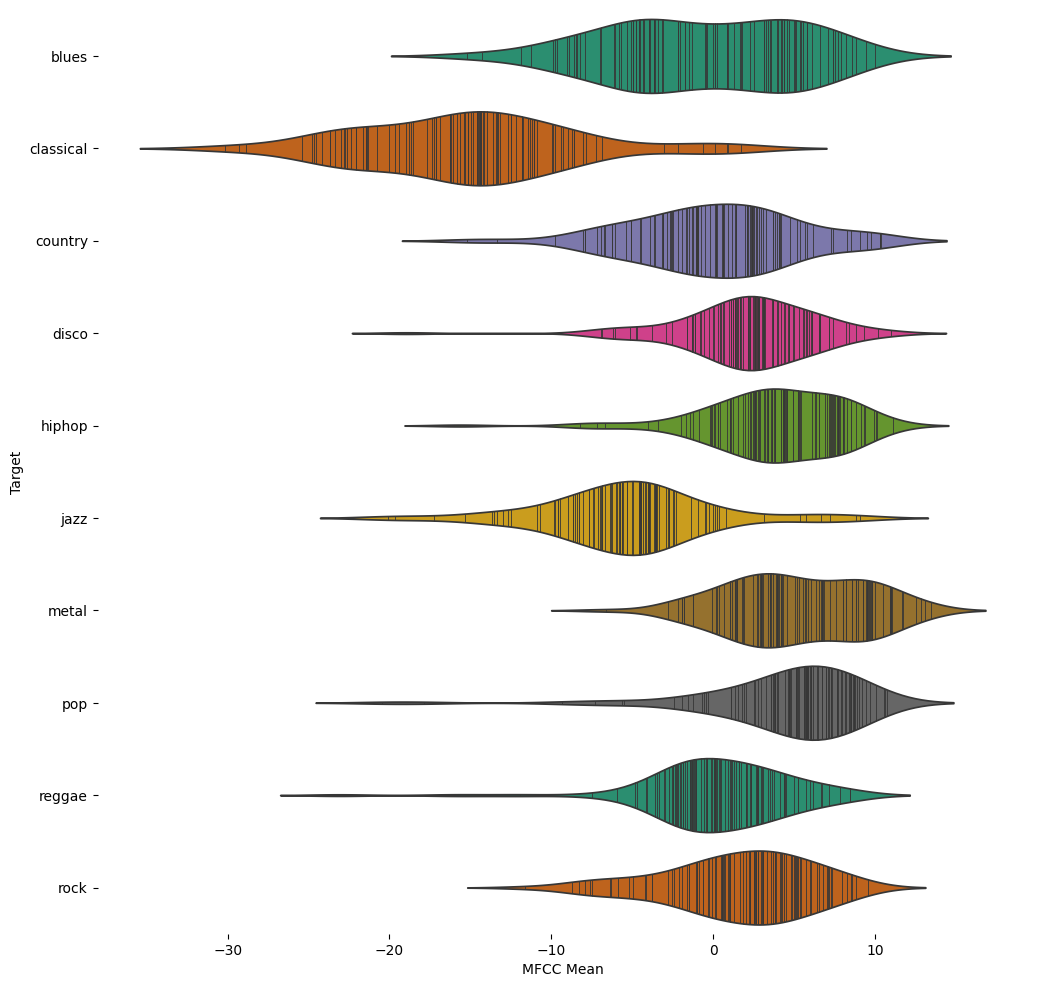

In [136]:
# @title Target vs MFCC Mean

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(final_df['Target'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(final_df, x='MFCC Mean', y='Target', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

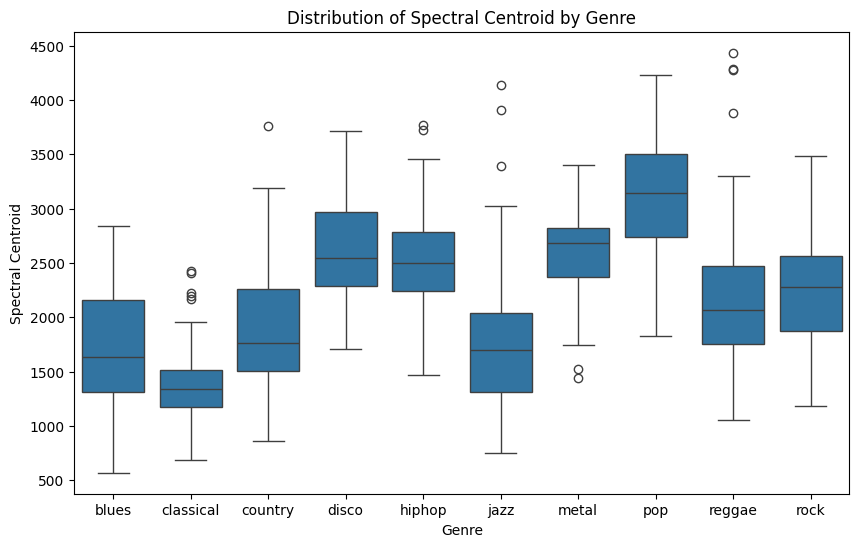

In [137]:
# @title Distribution of Spectral Centroid by Genre

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x='Target', y='Spectral Centroid', data=final_df)
plt.title('Distribution of Spectral Centroid by Genre')
plt.xlabel('Genre')
_ = plt.ylabel('Spectral Centroid')

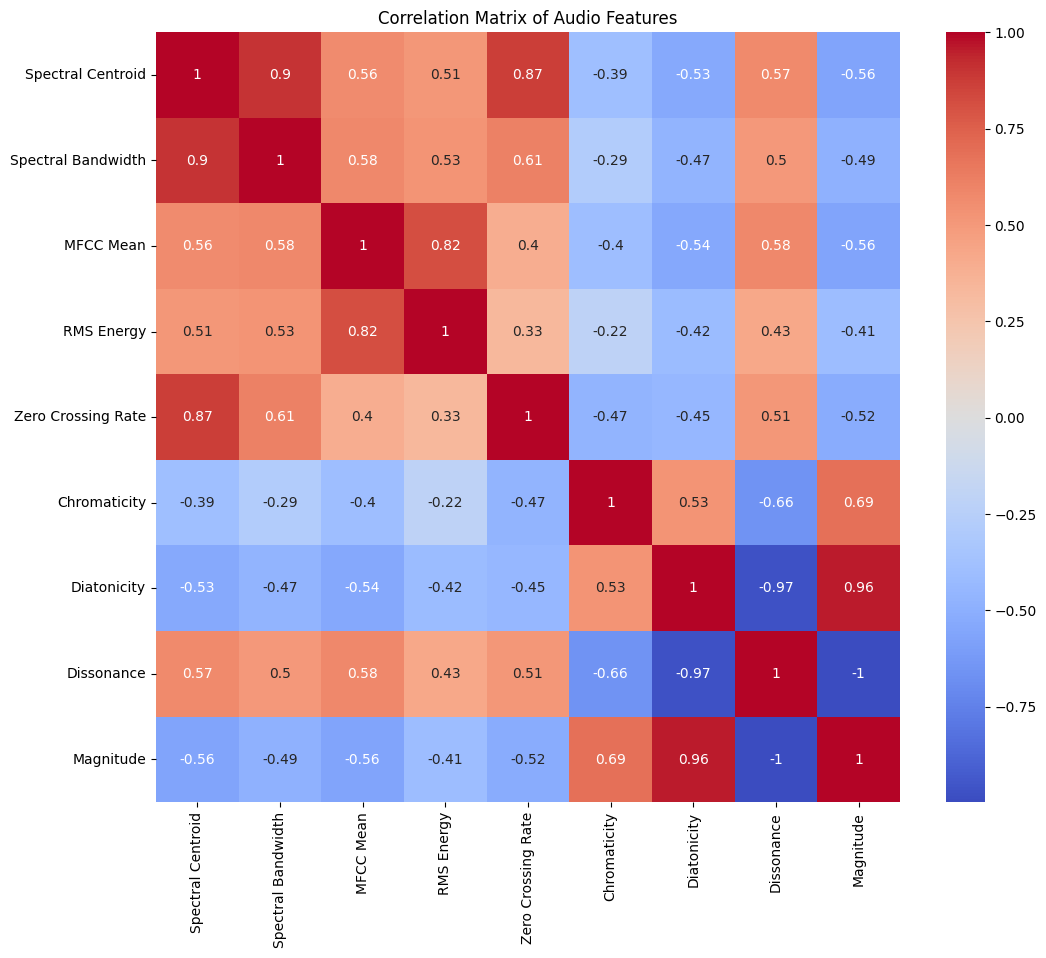

In [138]:
# @title Correlation Matrix of Audio Features

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 10))
num_features = ['Spectral Centroid', 'Spectral Bandwidth', 'MFCC Mean', 'RMS Energy', 'Zero Crossing Rate', 'Chromaticity', 'Diatonicity', 'Dissonance', 'Magnitude']
corr_matrix = final_df[num_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
_ = plt.title('Correlation Matrix of Audio Features')

Feature Importance

In [173]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np

X = final_df.drop(columns=['Target'])
y = final_df['Target']

model = RandomForestClassifier(random_state=42)
model.fit(X, y)

feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

top_features = feature_importances.head(10)
print(top_features)

                   Feature  Importance
0      Onset Strength Mean    0.086223
1      Percussive Variance    0.070518
2  Onset Strength Variance    0.068307
3                MFCC Mean    0.065591
4       Spectral Bandwidth    0.060096
5        Spectral Contrast    0.054498
6              Diatonicity    0.052848
7               RMS Energy    0.051173
8            MFCC Variance    0.048801
9             Chromaticity    0.047919


In [175]:
from sklearn.feature_selection import mutual_info_classif

X = final_df.drop(columns=['Target'])
y = final_df['Target']

mi_scores = mutual_info_classif(X, y, random_state=42)
mi_df = pd.DataFrame({
    'Feature': X.columns,
    'Mutual Information': mi_scores
}).sort_values(by='Mutual Information', ascending=False).reset_index(drop=True)

top_features = mi_df.head(10)
print(top_features)

                   Feature  Mutual Information
0      Percussive Variance            0.528817
1      Onset Strength Mean            0.528015
2         Spectral Rolloff            0.448208
3        Spectral Centroid            0.427279
4       Spectral Bandwidth            0.423693
5            MFCC Variance            0.420933
6  Onset Strength Variance            0.389971
7                MFCC Mean            0.387053
8               Dissonance            0.385749
9               RMS Energy            0.384584


___
## Latent Clustering

Lets reduce the dimensionality of the data to 3D, and place the data points in the latent space, colored by genre.

### UMAP

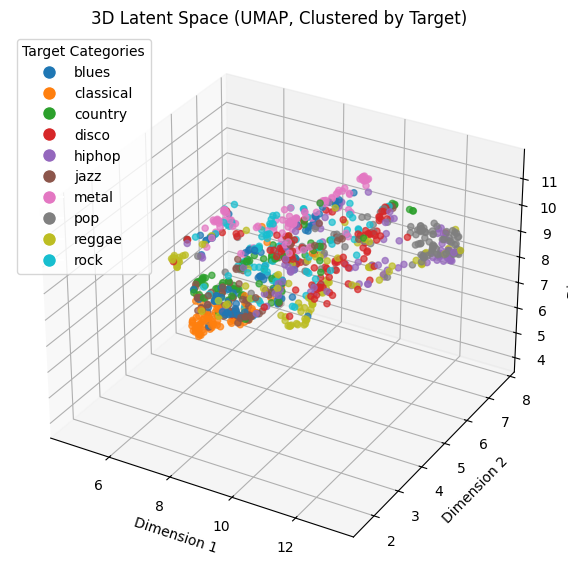

In [176]:
#!pip install umap-learn
import umap
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = final_df.drop(columns=["Target"])
y = final_df["Target"]
normalized_data = scaler.fit_transform(X)

categories = y.unique()
category_to_color = {cat: i for i, cat in enumerate(categories)}
color_map = get_cmap("tab10", len(categories))
colors = [color_map(category_to_color[cat]) for cat in y]

umap_reducer = umap.UMAP(n_components=3, random_state=42)
latent_space = umap_reducer.fit_transform(normalized_data)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")
scatter = ax.scatter(
    latent_space[:, 0],
    latent_space[:, 1],
    latent_space[:, 2],
    c=[category_to_color[cat] for cat in y],
    cmap=color_map,
    alpha=0.7,
)

legend_handles = [
    plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=color_map(i), markersize=10)
    for i in range(len(categories))
]
ax.legend(legend_handles, categories, title="Target Categories")

ax.set_title("3D Latent Space (UMAP, Clustered by Target)")
ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")
ax.set_zlabel("Dimension 3")
plt.show()

### T-SNE

[I 2024-12-23 11:37:44,071] A new study created in memory with name: no-name-612b3b62-552a-45d4-9c8e-7e75820a300d
[I 2024-12-23 11:38:27,599] Trial 0 finished with value: 30.85284423828125 and parameters: {'perplexity': 35.0, 'learning_rate': 24.384819081917218}. Best is trial 0 with value: 30.85284423828125.
[I 2024-12-23 11:39:10,086] Trial 1 finished with value: 1152.504638671875 and parameters: {'perplexity': 45.0, 'learning_rate': 316.64395059886505}. Best is trial 1 with value: 1152.504638671875.
[I 2024-12-23 11:39:51,784] Trial 2 finished with value: 3488.8271484375 and parameters: {'perplexity': 20.0, 'learning_rate': 520.4939083325637}. Best is trial 2 with value: 3488.8271484375.
[I 2024-12-23 11:40:31,032] Trial 3 finished with value: 5258.63134765625 and parameters: {'perplexity': 40.0, 'learning_rate': 628.335120772546}. Best is trial 3 with value: 5258.63134765625.
[I 2024-12-23 11:40:58,290] Trial 4 finished with value: 58.83700942993164 and parameters: {'perplexity': 2

Best Parameters: {'perplexity': 50.0, 'learning_rate': 776.1939866318652}


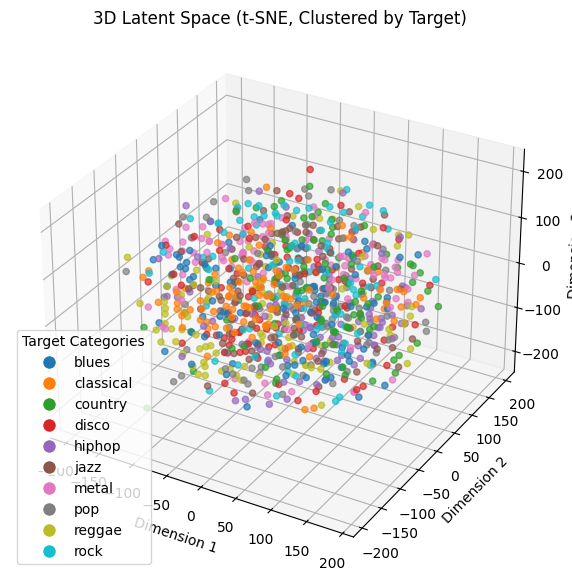

In [92]:
from sklearn.manifold import TSNE
import optuna
from sklearn.preprocessing import StandardScaler
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt

scaler = StandardScaler()
X = final_df.drop(columns=["Target"])
y = final_df["Target"]
normalized_data = scaler.fit_transform(X)

categories = y.unique()
category_to_color = {cat: i for i, cat in enumerate(categories)}
color_map = get_cmap("tab10", len(categories))
colors = [color_map(category_to_color[cat]) for cat in y]

def reduce_dimensionality(trial):
    perplexity = trial.suggest_float("perplexity", 5, 50, step=5)
    learning_rate = trial.suggest_float("learning_rate", 10, 1000, log=True)
    tsne = TSNE(
        n_components=3,
        perplexity=perplexity,
        learning_rate=learning_rate,
        random_state=42
    )
    return tsne.fit_transform(normalized_data)

def objective(trial):
    reduced_data = reduce_dimensionality(trial)
    return np.mean(np.var(reduced_data, axis=0))

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

best_params = study.best_params
print("Best Parameters:", best_params)

best_reduction = reduce_dimensionality(study.best_trial)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")
scatter = ax.scatter(
    best_reduction[:, 0],
    best_reduction[:, 1],
    best_reduction[:, 2],
    c=[category_to_color[cat] for cat in y],
    cmap=color_map,
    alpha=0.7,
)

legend_handles = [
    plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=color_map(i), markersize=10)
    for i in range(len(categories))
]
ax.legend(legend_handles, categories, title="Target Categories")

ax.set_title("3D Latent Space (t-SNE, Clustered by Target)")
ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")
ax.set_zlabel("Dimension 3")
plt.show()

U-MAP seems better at clustering the data points, so lets further improve it, by employing supervised information, and by pre-clustering the data.

1. Using the target label as a supervised guide, and cluster-based parameters:

Silhouette Score: 0.7900592088699341


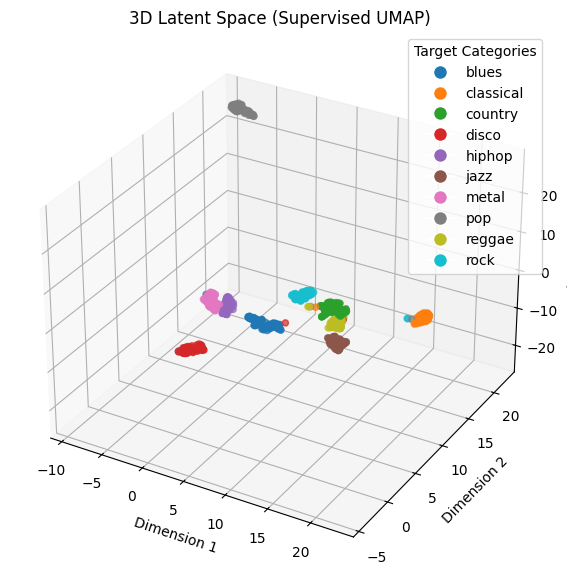

In [259]:
import umap
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from sklearn.metrics import silhouette_score

scaler = StandardScaler()
X = final_df.drop(columns=["Target"])
X["Tempo"] = X["Tempo"].astype(float)
y = final_df["Target"]
normalized_data = scaler.fit_transform(X)

label_encoder = LabelEncoder()
encoded_targets = label_encoder.fit_transform(y)

umap_reducer = umap.UMAP(
    n_components=3,
    random_state=42,
    metric="euclidean",
    n_neighbors=45,
    min_dist=0.3,
    target_metric="categorical",
)
latent_space = umap_reducer.fit_transform(normalized_data, y=encoded_targets)

score = silhouette_score(latent_space, encoded_targets)
print(f"Silhouette Score: {score}")

categories = y.unique()
category_to_color = {cat: i for i, cat in enumerate(categories)}
color_map = get_cmap("tab10", len(categories))

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")
scatter = ax.scatter(
    latent_space[:, 0],
    latent_space[:, 1],
    latent_space[:, 2],
    c=[category_to_color[cat] for cat in y],
    cmap=color_map,
    alpha=0.7,
)

legend_handles = [
    plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=color_map(i), markersize=10)
    for i in range(len(categories))
]
ax.legend(legend_handles, categories, title="Target Categories")

ax.set_title("3D Latent Space (Supervised UMAP)")
ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")
ax.set_zlabel("Dimension 3")
plt.show()

2. Pre-clustering:

Silhouette Score: -0.05795059725642204


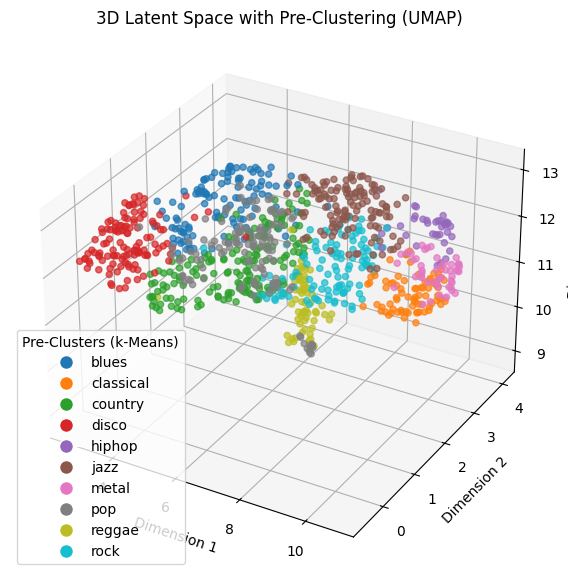

In [202]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import umap
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

scaler = StandardScaler()
X = final_df.drop(columns=["Target"])
X["Tempo"] = X["Tempo"].astype(float)
y = final_df["Target"]
normalized_data = scaler.fit_transform(X)

num_clusters = len(y.unique())
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(normalized_data)

categories = y.unique()
category_to_color = {cat: i for i, cat in enumerate(categories)}
color_map = get_cmap("tab10", len(categories))
colors = [color_map(category_to_color[cat]) for cat in y]

umap_reducer = umap.UMAP(
    n_components=3,
    random_state=42,
    n_neighbors=55,
    min_dist=0.2,
)
latent_space = umap_reducer.fit_transform(normalized_data)

score = silhouette_score(latent_space, encoded_targets)
print(f"Silhouette Score: {score}")

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")
scatter = ax.scatter(
    latent_space[:, 0],
    latent_space[:, 1],
    latent_space[:, 2],
    c=cluster_labels,
    cmap=color_map,
    alpha=0.7,
)

legend_handles = [
    plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=color_map(i), markersize=10)
    for i in range(num_clusters)
]
ax.legend(legend_handles, categories, title="Pre-Clusters (k-Means)")
ax.set_title("3D Latent Space with Pre-Clustering (UMAP)")
ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")
ax.set_zlabel("Dimension 3")
plt.show()

As it can be seen, using pre-clustering is beneficial.

Tuning parameters:

[I 2024-12-23 15:14:32,202] A new study created in memory with name: no-name-8347544a-ae67-4ce5-9934-4936f16ff2ed
[I 2024-12-23 15:14:40,535] Trial 0 finished with value: 0.43808677792549133 and parameters: {'n_neighbors': 73, 'min_dist': 0.011127501212605374}. Best is trial 0 with value: 0.43808677792549133.
[I 2024-12-23 15:14:45,891] Trial 1 finished with value: 0.31068435311317444 and parameters: {'n_neighbors': 59, 'min_dist': 0.6662259546576337}. Best is trial 0 with value: 0.43808677792549133.
[I 2024-12-23 15:14:50,054] Trial 2 finished with value: 0.35680827498435974 and parameters: {'n_neighbors': 74, 'min_dist': 0.29013912798067787}. Best is trial 0 with value: 0.43808677792549133.
[I 2024-12-23 15:14:54,876] Trial 3 finished with value: 0.3017703890800476 and parameters: {'n_neighbors': 88, 'min_dist': 0.8626269409878728}. Best is trial 0 with value: 0.43808677792549133.
[I 2024-12-23 15:15:00,793] Trial 4 finished with value: 0.3003009259700775 and parameters: {'n_neighbor

Best Silhouette Score: 0.4904455244541168
Best Parameters: {'n_neighbors': 8, 'min_dist': 0.015636357438835707}


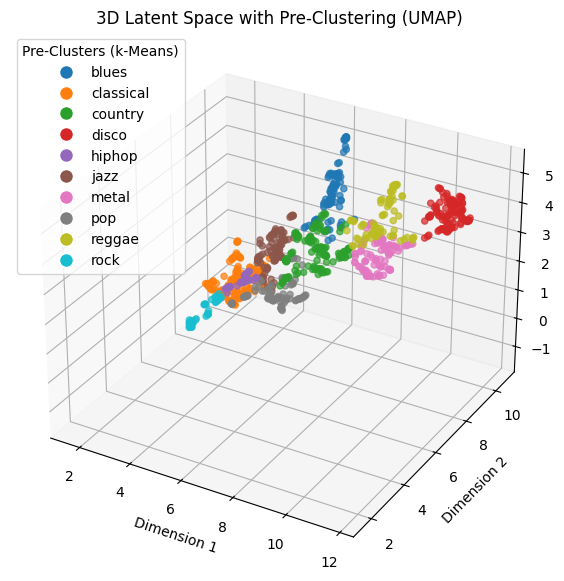

In [228]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import umap
import optuna

def objective(trial):
    n_neighbors = trial.suggest_int("n_neighbors", 5, 100)
    min_dist = trial.suggest_float("min_dist", 0.0, 0.9)
    n_components = 3

    umap_reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        random_state=42,
    )
    latent_space = umap_reducer.fit_transform(normalized_data)

    kmeans = KMeans(
        n_clusters=len(y.unique()),
        init="k-means++",
        random_state=42,
        n_init=10,
    )
    cluster_labels = kmeans.fit_predict(latent_space)

    score = silhouette_score(latent_space, cluster_labels)
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

best_params = study.best_params
best_score = study.best_value
print(f"Best Silhouette Score: {best_score}")
print(f"Best Parameters: {best_params}")

umap_reducer = umap.UMAP(
    n_neighbors=best_params["n_neighbors"],
    min_dist=best_params["min_dist"],
    n_components=3,
    random_state=42,
)
final_latent_space = umap_reducer.fit_transform(normalized_data)

kmeans = KMeans(
    n_clusters=len(y.unique()),
    init="k-means++",
    random_state=42,
    n_init=10,
)
final_cluster_labels = kmeans.fit_predict(final_latent_space)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")
scatter = ax.scatter(
    final_latent_space[:, 0],
    final_latent_space[:, 1],
    final_latent_space[:, 2],
    c=final_cluster_labels,
    cmap=color_map,
    alpha=0.7,
)

legend_handles = [
    plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=color_map(i), markersize=10)
    for i in range(num_clusters)
]
ax.legend(legend_handles, categories, title="Pre-Clusters (k-Means)")
ax.set_title("3D Latent Space with Pre-Clustering (UMAP)")
ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")
ax.set_zlabel("Dimension 3")
plt.show()

___
## Classify new Samples

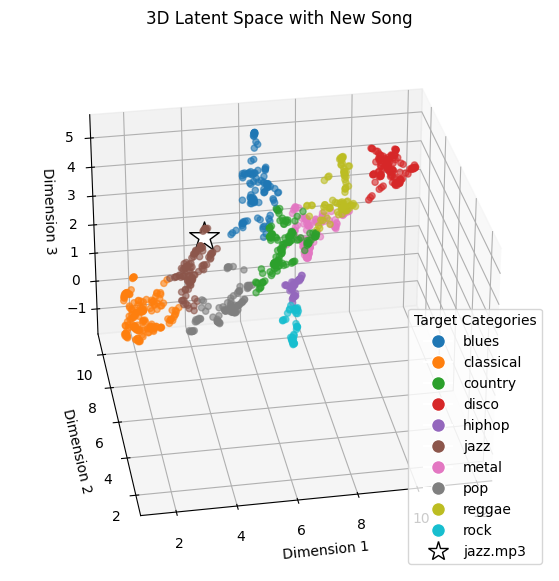

New Song Report for: jazz.mp3
Assigned Genre: jazz

Feature Statistics:
Spectral Centroid: 2205.0438
Spectral Bandwidth: 3453.2579
Spectral Rolloff: 5117.4798
RMS Energy: 0.2003
Zero Crossing Rate: 0.0257
MFCC Mean: 0.9145
MFCC Variance: 7328.9561
Spectral Contrast: 23.6900
Harmony Mean: -0.0000
Harmony Variance: 0.0381
Percussive Mean: 0.0000
Percussive Variance: 0.0022
Tempo: 117.1875
Onset Strength Mean: 1.3152
Onset Strength Variance: 4.2186
Mean Beat Interval: 0.5233
Chromaticity: 0.2117
Diatonicity: 0.1558
Dissonance: 0.8524
Magnitude: 1.4021



In [258]:
def pre_cluster_data(latent_space, n_clusters=10):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clustering_labels = kmeans.fit_predict(latent_space)
    return clustering_labels, kmeans

def project_new_song_to_latent_space(new_song_file, umap_reducer, scaler, final_df, y):
    y_new, sr_new = librosa.load(new_song_file, sr=None)

    features = extract_features(y_new, sr_new)

    X_new = pd.DataFrame([features])
    normalized_features = scaler.transform(X_new)

    new_song_latent = umap_reducer.transform(normalized_features)

    return new_song_latent, features

def generate_report(new_song_file, umap_reducer, scaler, final_df, y, clustering_labels, kmeans):
    new_song_latent, features = project_new_song_to_latent_space(new_song_file, umap_reducer, scaler, final_df, y)

    distances_to_centroids = np.linalg.norm(kmeans.cluster_centers_ - new_song_latent, axis=1)
    closest_cluster_idx = np.argmin(distances_to_centroids)

    closest_category = np.unique(y)[closest_cluster_idx]

    report = f"New Song Report for: {new_song_file}\n"
    report += f"Assigned Genre: {closest_category}\n\n"
    report += "Feature Statistics:\n"
    for feature, value in features.items():
        if isinstance(value, np.ndarray):
            value = value[0]
        report += f"{feature}: {value:.4f}\n"

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection="3d")

    categories = y.unique()
    category_to_color = {cat: i for i, cat in enumerate(categories)}
    color_map = get_cmap("tab10", len(categories))

    scatter_existing = ax.scatter(final_df[:, 0], final_df[:, 1], final_df[:, 2],
                                  c=clustering_labels, cmap=color_map, alpha=0.6)
    new_song_latent[0, 2] += 0.5 # adjust position to make it more visible
    new_song_latent[0, 1] -= 0.5 # adjust position to make it more visible
    scatter_new_song = ax.scatter(new_song_latent[0, 0], new_song_latent[0, 1], new_song_latent[0, 2],
                                  c='white', marker='*', edgecolors='black', s=500,
                                  label=new_song_file)

    legend_handles = [
        plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=color_map(i), markersize=10)
        for i in range(len(categories))
    ]
    ax.legend(legend_handles + [plt.Line2D([0], [0], marker='*', color='w', markerfacecolor='white', markeredgecolor='black', markersize=15)],
              categories.tolist() + [new_song_file], title="Target Categories")

    ax.set_title("3D Latent Space with New Song")
    ax.set_xlabel("Dimension 1")
    ax.set_ylabel("Dimension 2")
    ax.set_zlabel("Dimension 3")

    ax.view_init(azim=-100, elev=30) # change view angles
    plt.show()

    return report

report = generate_report('jazz.mp3', umap_reducer, scaler, final_latent_space, y, final_cluster_labels, kmeans)
print(report)